In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from astropy import units
from galpy.orbit import Orbit
from FerrersPotential import FerrersPotential as FP
from galpy.potential import PlummerPotential as PP

In [4]:
%%prun -s cumulative
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
ts = np.linspace(0,34,500)
omwa = Orbit(vxvv=[1,0.25,0.7,0,0.0,0]) #[R,vR,vT,z,vz,phi]
omwb = Orbit(vxvv=[1,0.25,0.7,0,0.0,0]) #[R,vR,vT,z,vz,phi]

#omwa.integrate(ts, pmw, method = 'leapfrog')
#omwb.integrate(ts, ps, method = 'leapfrog')

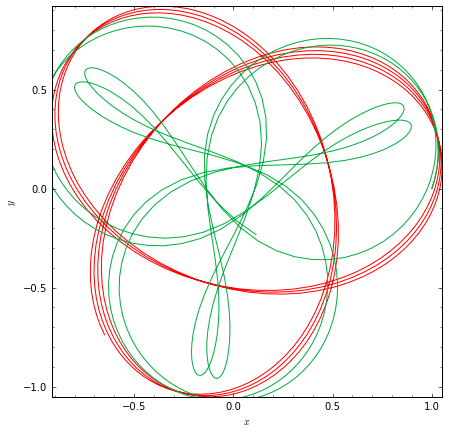

In [7]:
matplotlib.rcParams['figure.figsize'] = (7,7)
omwb.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'red')
omwa.plot(d1 = 'x', d2 = 'y', overplot = True, color = '#00AF3F')

In [192]:
ts = np.linspace(0,500,5000)
omwf = Orbit(vxvv=[1,0.25,0.6,0,0.0,0]) #[R,vR,vT,z,vz,phi]

omwf.integrate(ts, pmw, method = 'leapfrog')

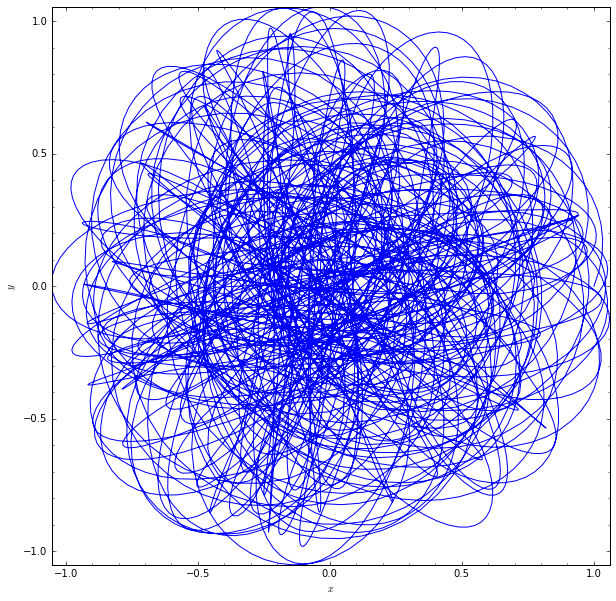

In [193]:
omwf.plot(d1 = 'x', d2 = 'y')

In [552]:
omwg.integrate(ts, ps, method = 'leapfrog')

# ======================  useful functions  =========================

In [123]:
def rot(omega, t):
    temp = [[np.cos(t*omega), np.sin(t*omega)], [-np.sin(t*omega), np.cos(t*omega)]]
    return np.array(temp)

def inrotframe(x,y, ts, potential):
    xy = np.zeros([len(x),2])
    xy[:,0] = x
    xy[:,1] = y
    omega = potential.OmegaP()
    xrot, yrot = np.zeros(len(ts)), np.zeros(len(ts))
    for i in range(len(ts)):
        xrot[i],yrot[i] = np.dot(xy[i],rot(omega, ts[i]))
    return xrot, yrot

In [13]:
def allorbits(x,y):
    xo = [x[2*i] for i in range(int(len(x)/2))]
    xo1 = [x[2*i+1] for i in range(int(len(x)/2))]
    yo = [y[2*i] for i in range(int(len(x)/2))]
    yo1 = [y[2*i+1] for i in range(int(len(x)/2))]
    return [xo,yo],[xo1,yo1]

# ====================  Lyapunov exponent  =======================

In [5]:
x = []
y = []
def evolveorbit(icon, ti, tau, pot):
    global x
    global y
    o = Orbit(vxvv=icon) # [R,vR,vT,z,vz,phi]
    tf = ti+tau
    ts = np.linspace(ti,tf,100)
    o.integrate(ts, pot, method = 'leapfrog')
    x.append(o.x(ts[0]))
    y.append(o.y(ts[0]))
    return [o.R(tf),o.vR(tf),o.vT(tf),o.z(tf),o.vz(tf),o.phi(tf)]  #for full 3D orbit (values can be zero though)

In [6]:
def dvector(o,d):
    return np.array(d)-np.array(o)

In [7]:
def alpha(delta):
    size = np.linalg.norm(delta)
    return size, delta/size

In [8]:
def LEs(time, size, initsize):
    return np.log(size/initsize)

In [9]:
def lyapunov(o,tau, potential, Tm):
    global x
    global y
    x,y = [],[]
    time,LE = [],[] # array large enough
    continuing = True
    i = 1
    w = [1.,0.,0.,0.,0.,0.] # initial setting of deviation vector
    initsize = 1e-5 # may be useful to have it as a parameter of the function
    while continuing:
        icdo = list(np.array(o)+initsize*np.array(w)) # initial conditions for evolved orbit
        newo = evolveorbit(o, tau*i, tau, potential) # integration of tested orbit
        newdo = evolveorbit(icdo, tau*i, tau, potential) # integration of deviated orbit
        wj = dvector(o=newo,d=newdo) # deviation vector after integration
        size, veps0 = alpha(wj) # size of the upper, new deviation vector of size eps0
        LE.append(LEs(tau*i, size, initsize))
        time.append(tau*i)
        if i*tau > Tm:
            break
        i += 1
        o = newo 
        w = veps0
    A = np.array([sum(LE[:i]) / time[i] for i in range(len(time))])
    return A, time

In [10]:
#%%prun -s cumulative
#pmw = PP()
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([1.,0.25,0.7,0.,0.,0.])
tau = 0.01
Tm = 100
les, time = lyapunov(icon, tau, pmw, Tm)

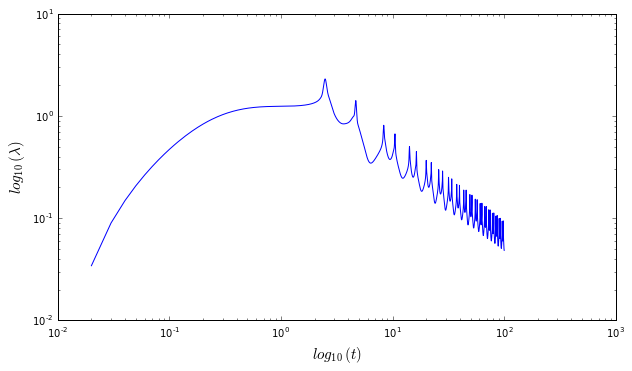

In [11]:
matplotlib.rcParams['figure.figsize'] = (10.0, 5.5)
plt.loglog(time, les)
plt.xlabel(r'$log_{10}\,(t)$', fontsize = 15)
plt.ylabel(r'$log_{10}\,(\lambda)$', fontsize = 15)
#plt.xlim(0,3)

In [14]:
[xo,yo], [xo1,yo1] = allorbits(x, y)

(-1.2, 1.2)

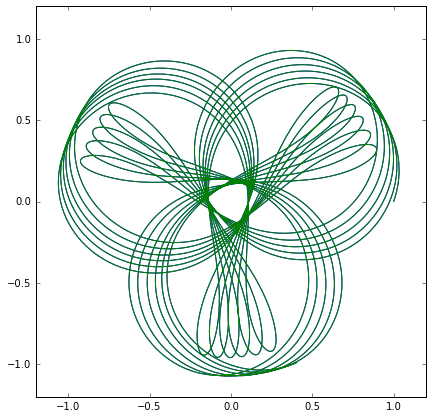

In [15]:
matplotlib.rcParams['figure.figsize'] = (7,7)
plt.plot(xo,yo)
plt.plot(xo1,yo1)
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)

In [448]:
diff = []
for i in range(len(xo)):
    diff.append((xo[i]-xo1[i])**2+(yo[i]-yo1[i])**2)

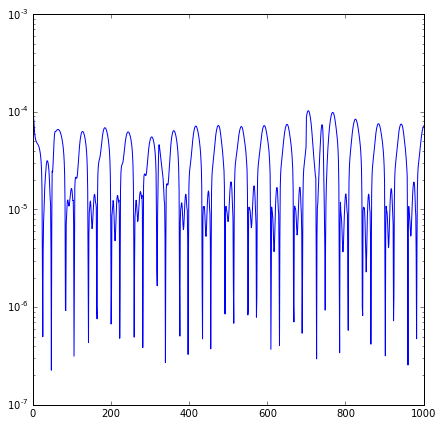

In [451]:
plt.semilogy(diff)

In [16]:
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
orb = Orbit(vxvv = [1,0.25,0.6,0,0.0,0])
timespan = np.linspace(0,100,1000)
orb.integrate(timespan, pmw, method = 'leapfrog')

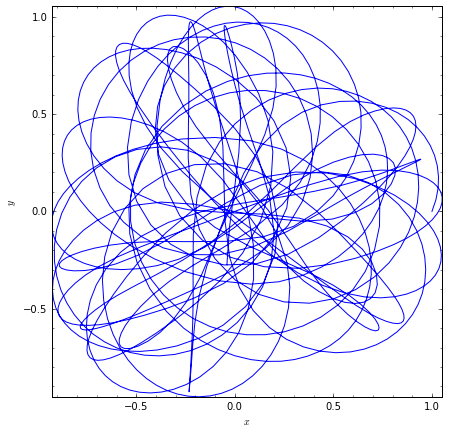

In [17]:
matplotlib.rcParams['figure.figsize'] = (7,7)
orb.plot(d1 = 'x', d2 = 'y')

In [18]:
%%prun -s cumulative
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([1.,0.25,0.6,0.,0.,0.])
tau = 0.01
Tm = 200
les, time = lyapunov(icon, tau, pmw, Tm)

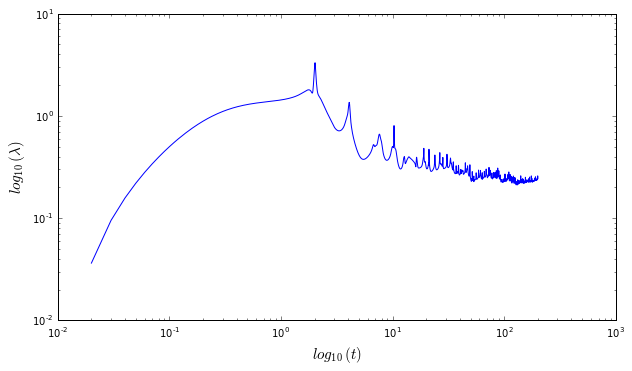

In [19]:
matplotlib.rcParams['figure.figsize'] = (10.0, 5.5)
plt.loglog(time, les)
plt.xlabel(r'$log_{10}\,(t)$', fontsize = 15)
plt.ylabel(r'$log_{10}\,(\lambda)$', fontsize = 15)